In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

In [18]:
# Sumber Data: https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data
# Load Dataset
df = pd.read_csv("enhanced_anxiety_dataset.csv")
df.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [3]:
# Mengecek dan menangani missing value 
print("Missing values:")
print(df.isnull().sum())
df.dropna(inplace=True)

Missing values:
Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64


In [4]:
# Binarisasi Target 
# Anggap: Anxiety Level 6 ke atas = tinggi (1), di bawah 6 = rendah (0)
df["Anxiety_Binary"] = (df["Anxiety Level (1-10)"] >= 6).astype(int)

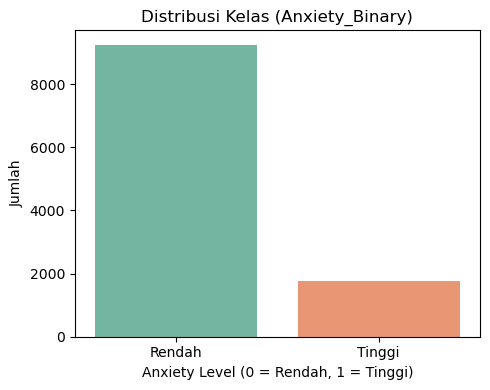

In [5]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Anxiety_Binary", data=df, hue="Anxiety_Binary", palette="Set2", legend=False)
plt.title("Distribusi Kelas (Anxiety_Binary)")
plt.xlabel("Anxiety Level (0 = Rendah, 1 = Tinggi)")
plt.ylabel("Jumlah")
plt.xticks([0, 1], ["Rendah", "Tinggi"])
plt.tight_layout()
plt.show()

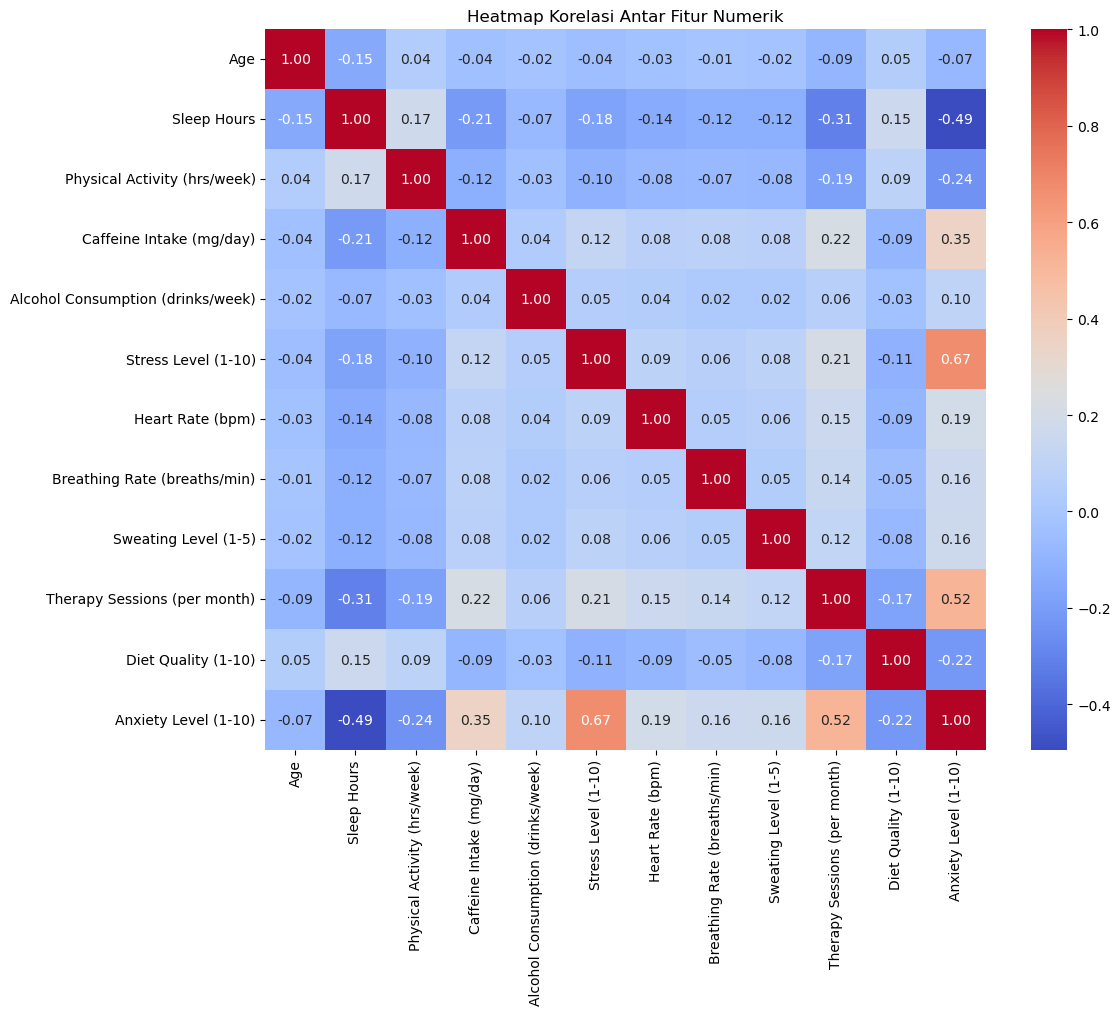

In [6]:
# Ambil hanya kolom numerik (termasuk Anxiety_Binary)
df_numerik = df.select_dtypes(include=["int64", "float64"])

# === Heatmap Korelasi ===
plt.figure(figsize=(12, 10))
correlation = df_numerik.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()


In [7]:
# Pisahkan Fitur dan Label 
X = df.drop(["Anxiety Level (1-10)", "Anxiety_Binary"], axis=1)
y = df["Anxiety_Binary"]

In [8]:
# Encode Kolom Kategorikal
label_encoders = {}
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [9]:
# Scaling Kolom Numerik 
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Training Model 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Evaluasi Model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n📊 Evaluasi Model:")
print(f"Akurasi       : {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score : {roc_auc_score(y_test, y_proba):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


📊 Evaluasi Model:
Akurasi       : 0.93
ROC AUC Score : 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1849
           1       0.97      0.60      0.74       351

    accuracy                           0.93      2200
   macro avg       0.95      0.80      0.85      2200
weighted avg       0.93      0.93      0.93      2200



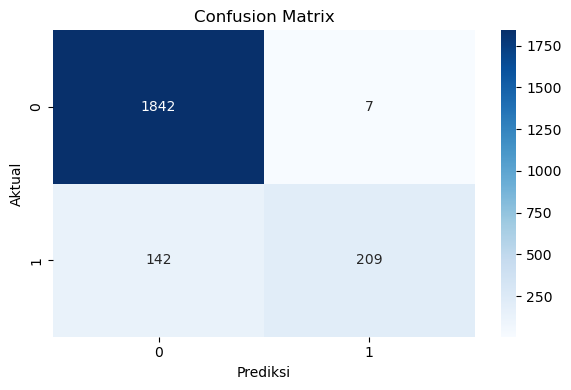

In [13]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

In [14]:
# Simpan Model dan Preprocessing Tools
with open("mental_health_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("\n✅ Model, scaler, dan encoder berhasil disimpan.")


✅ Model, scaler, dan encoder berhasil disimpan.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# === Daftar Model ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# === Training dan Evaluasi Semua Model ===
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

    print(f"\n📌 Model: {name}")
    print(f"Akurasi       : {accuracy:.2f}")
    print(f"ROC AUC Score : {roc if roc=='N/A' else f'{roc:.2f}'}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "roc_auc": roc
    }



📌 Model: Logistic Regression
Akurasi       : 0.93
ROC AUC Score : 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1849
           1       0.85      0.66      0.75       351

    accuracy                           0.93      2200
   macro avg       0.90      0.82      0.85      2200
weighted avg       0.93      0.93      0.92      2200


📌 Model: K-Nearest Neighbors
Akurasi       : 0.93
ROC AUC Score : 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      1849
           1       0.88      0.63      0.73       351

    accuracy                           0.93      2200
   macro avg       0.91      0.81      0.85      2200
weighted avg       0.92      0.93      0.92      2200


📌 Model: Support Vector Machine
Akurasi       : 0.93
ROC AUC Score : 0.94
Classification Report:
               precision    recall  f1-score   support



C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 Model: XGBoost
Akurasi       : 0.92
ROC AUC Score : 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1849
           1       0.82      0.66      0.73       351

    accuracy                           0.92      2200
   macro avg       0.88      0.82      0.84      2200
weighted avg       0.92      0.92      0.92      2200



C:\Users\HP\AppData\Local\Temp\ipykernel_24208\3523081716.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


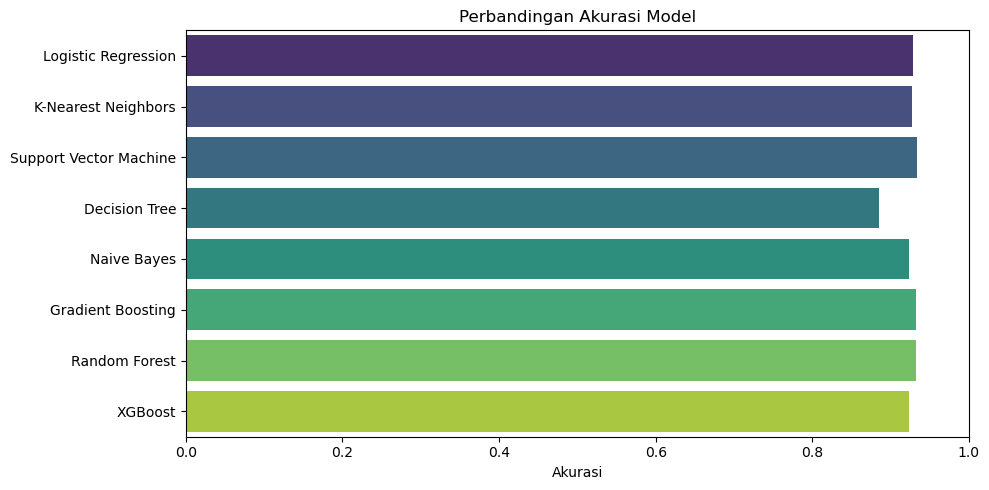

In [16]:
# Visualisasi Akurasi Semua Model
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]

sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Akurasi")
plt.title("Perbandingan Akurasi Model")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
